In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d splcher/animefacedataset

 99% 389M/395M [00:04<00:00, 77.5MB/s]
100% 395M/395M [00:04<00:00, 84.0MB/s]


In [ ]:
!unzip animefacedataset -d '/content/AnimeFaces/' 

Streaming output truncated to the last 5000 lines.
  inflating: /content/AnimeFaces/images/62764_2019.jpg  
  inflating: /content/AnimeFaces/images/62765_2019.jpg  
  inflating: /content/AnimeFaces/images/62766_2019.jpg  
  inflating: /content/AnimeFaces/images/62767_2019.jpg  
  inflating: /content/AnimeFaces/images/62768_2019.jpg  
  inflating: /content/AnimeFaces/images/62769_2019.jpg  
  inflating: /content/AnimeFaces/images/6276_2003.jpg  
  inflating: /content/AnimeFaces/images/62770_2019.jpg  
  inflating: /content/AnimeFaces/images/62771_2019.jpg  
  inflating: /content/AnimeFaces/images/62772_2019.jpg  
  inflating: /content/AnimeFaces/images/62773_2019.jpg  
  inflating: /content/AnimeFaces/images/62774_2019.jpg  
  inflating: /content/AnimeFaces/images/62775_2019.jpg  
  inflating: /content/AnimeFaces/images/62776_2019.jpg  
  inflating: /content/AnimeFaces/images/62777_2019.jpg  
  inflating: /content/AnimeFaces/images/62778_2019.jpg  
  inflating: /content/AnimeFaces/image

# DCGAN 
## Deep Convolutional Generative Adversarial Network

<img src="https://raw.githubusercontent.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/master/CelebA_DCGAN_crop_results/generation_animation.gif">

### This notebook is an introduction to Deep Convolutional GANs. I have attempted to provide an intuitive explanation of what GANs are, how to build a GAN. In order to keep it simple I have used the Anime Face dataset which contains the pictures of faces cartoon characters. So, without any further delay, let's get right into it.

## Objectives:
   * To demonstrate and explain the working of a GAN.
   * To demonstrate how to build and train a GAN with pytorch.

## Q) What is a GAN ?
Imagine a situation in which person A always lies to person B and person B tries to catch the lie. If they continue this game for a long time, eventually person A will get pretty good at lying to person B and person A will get pretty good at catching the lies of person A. 

If we can come up with any such situation in which teo entities are continusly trying to get the upper hand by competing against one another, then we will be able to get an intuition about how GANS work.

### GANS are very simillar to this condition !!!!



## Overview of the GAN structure

A generative adversarial network (GAN) has two parts:

   * The generator learns to generate plausible data. The generated instances become negative training examples        for the discriminator.
    
   * The discriminator learns to distinguish the generator's fake data from real data. The discriminator penalizes      the generator for producing implausible results.

When the training begins, the generator produces obviously fake data, and the discriminator quickly learns to tell that it's fake:

<img src="https://developers.google.com/machine-learning/gan/images/bad_gan.svg">

As the training progresses, the generator gets closer to producing output that can fool the discriminator:

<img src="https://developers.google.com/machine-learning/gan/images/ok_gan.svg">

Finally, if the generator training goes well, the discriminator gets worse at telling the difference between real and fake. It starts to classify fake data as reak, and it's accuracy decreases. This means that the generator is getting good at producing fake data. 

<img src="https://developers.google.com/machine-learning/gan/images/good_gan.svg">

## How does a GAN look ?

Well, here is a picture of the whole system:

<img src="https://developers.google.com/machine-learning/gan/images/gan_diagram.svg">

Both the generator and the discriminator are neural networks. The generator output is connected directly to the discriminator input. Through the process of backpropagation, the discriminator's classification provides a signal that the generator uses to update its weights.

Before diving any deeper into the workings of a GAN, let's get started with building it and we can understand as we proceed.

## Import Necessary Libraries

In our notebook we will be using Pytorch. Pytorch is an open source machine learning frameowrk developed by Facebook. We will also be using matplotlib to ot the lodd graphs, tqdm to monitor the epochs and PIL to preprocess the images.   

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset 
import cv2
from PIL import Image
import numpy as np
from PIL import ImageFile
import csv
import  tqdm
 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from IPython.display import display
to_pil = torchvision.transforms.ToPILImage()
import random
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Let's define some variables:

   * <b>dataroot</b> - the path to the root of the dataset folder. 
   * <b>workers</b> -the number of worker threads for loading the data with the DataLoader
   * <b>batch_size</b> - the batch size used in training. The DCGAN paper uses a batch size of 128
   * <b>image_size</b> - the spatial size of the images used for training. 
   * <b>nc</b> - number of color channels in the input image. here we are using RGB images, hence nc = 3
   * <b>nz</b> - length of the latent vector
   * <b>ngf</b> - relates to the depth of the feature maps carried through the generator 
   * <b>ndf</b> - sets the depth of feature maps propagated through the discriminator
   * <b>num_epochs</b> - number of training epochs to run. Training for longer will lead to better results but it will take a lot of time.
   * <b>lr</b> - learning rate for traininnn. As described in the DCGAN paper this should be 0.0002
   * <b>beta1</b> - beta1 hyperparametter for am optimizer. As described in the DCGAN paper this should be 0.5
   * <b>ngpu</b> - number of GPUs available. If this is 0, code will run in CPU mode.

In [ ]:
# Root directory for dataset
dataroot = "/content/AnimeFaces"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Data

In this session, we will be using the Celeb-A Faces dataset. The dataset is downloaded from kaggle and is unzipped in the google colab runtime. The directory structure is:
<b>
<div class="highlight-default notranslate"><div class="highlight"><pre><span></span><span class="n">/</span><span class="o">content</span><span class="n">/</span><span class="o">AnimeFaces</span>
    <span class="o">-&gt;</span> <span class="n">images</span>
        <span class="o">-&gt;</span> <span class="mf">188242.</span><span class="n">jpg</span>
        <span class="o">-&gt;</span> <span class="mf">173822.</span><span class="n">jpg</span>
        <span class="o">-&gt;</span> <span class="mf">284702.</span><span class="n">jpg</span>
        <span class="o">-&gt;</span> <span class="mf">537394.</span><span class="n">jpg</span>
           <span class="o">...</span>
</pre></div>
</div></b>

This is an important step because we will be using the <b>ImageFolder</b> dataset class, which requires there to be subdirectories in the dataset’s root folder. Now, we can create the dataset, create the dataloader, set the device to run on, and finally visualize some of the training data.

<b>We will be using the following transformations on the images:</b>
   * We will be resizing the images to be 64x46 images
   * We will be converting these images to torch tensors
   * We will normalizing the pixel values to bring them between -1 and 1 because that is the range of the Tanh() function

In [ ]:
#Defining the transformations to be applied on the images
transform = transforms.Compose([
    transforms.Resize((64 , 64)) , 
    transforms.ToTensor() , 
    transforms.Normalize((0.5 , 0.5 , 0.5), (0.5 , 0.5 , 0.5)),
])

# Creating the dataset by using the ImageFolder class
dataset = torchvision.datasets.ImageFolder(root = dataroot, transform = transform)

#loading the data using pytorch's DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last = True, shuffle=True)

# Defining the device. Here we will be using an Nvidia GPU in order to train the Neural Network.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### LET'S SEE THE TRAINING IMAGES !!

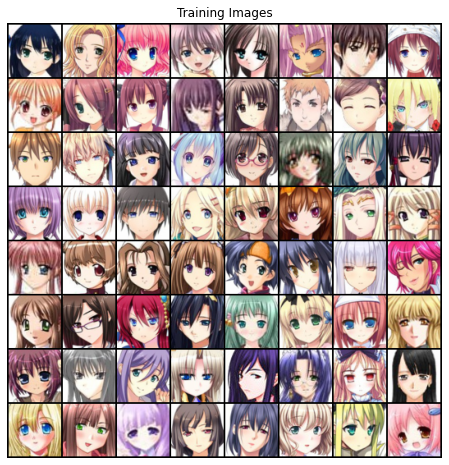

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Implementation

With our input parameters set and the dataset prepared, we can now get into the implementation. We will start with the weigth initialization strategy, then talk about the generator, discriminator, loss functions, and training loop in detail.

## Weight Initialization

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The <b>weights_init</b> function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Now that all the preprocessing parts are completed, let's get started with building the model

<div class="section" id="generator">
<h3>Generator<a class="headerlink" href="#generator" title="Permalink to this headline"></a></h3>
<p>The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator. It learns to make the discriminator classify its output as real.   
The generator, <span class="math notranslate nohighlight">\(G\)</span>, is designed to map the latent space vector
(<span class="math notranslate nohighlight">\(z\)</span>) to data-space. Since our data are images, converting
<span class="math notranslate nohighlight">\(z\)</span> to data-space means ultimately creating a RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2d batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of <span class="math notranslate nohighlight">\([-1,1]\)</span>. It is worth
noting the existence of the batch norm functions after the
conv-transpose layers, as this is a critical contribution of the DCGAN
paper. These layers help with the flow of gradients during training. An
image of the generator from the DCGAN paper is shown below.</p>

<div class="figure">
<img alt="dcgan_generator" src="https://pytorch.org/tutorials/_images/dcgan_generator.png"/>
</div>
    
<p>Notice, the how the inputs we set in the input section (<em>nz</em>, <em>ngf</em>, and
<em>nc</em>) influence the generator architecture in code. <em>nz</em> is the length
of the z input vector, <em>ngf</em> relates to the size of the feature maps
that are propagated through the generator, and <em>nc</em> is the number of
channels in the output image (set to 3 for RGB images).</p>

<p><b>Generator Code:</b></p>

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

<p><b>Now, we can instantiate the generator and apply the <code class="docutils literal notranslate"><span class="pre">weights_init</span></code>
function. Check out the printed model to see how the generator object is
    structured.</b></p>

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


<div class="section" id="discriminator">
<h3>Discriminator<a class="headerlink" href="#discriminator" title="Permalink to this headline"></a></h3>
<p>As mentioned, the discriminator, <span class="math notranslate nohighlight">\(D\)</span>, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, <span class="math notranslate nohighlight">\(D\)</span> takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and LeakyReLUs. The
DCGAN paper mentions it is a good practice to use strided convolution
rather than pooling to downsample because it lets the network learn its
own pooling function. Also batch norm and leaky relu functions promote
healthy gradient flow which is critical for the learning process of both
<span class="math notranslate nohighlight">\(G\)</span> and <span class="math notranslate nohighlight">\(D\)</span>.</p>
 
<div class="figure">
<img alt="dcgan_discriminator" src="https://miro.medium.com/max/924/1*Sa16hNLBZEP_7_B8M9M8bA.png"/>
</div>
 
<p><b>Discriminator Code :</b></p>

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

<p><b>Now, as with the generator, we can create the discriminator, apply the
<code class="docutils literal notranslate"><span class="pre">weights_init</span></code> function, and print the model’s structure.</b></p>

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


div class="section" id="loss-functions-and-optimizers">
<h3>Loss Functions and Optimizers<a class="headerlink" href="#loss-functions-and-optimizers" title="Permalink to this headline"></a></h3>
<p>With <span class="math notranslate nohighlight">\(D\)</span> and <span class="math notranslate nohighlight">\(G\)</span> setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss function which is defined in PyTorch as:</p>
<div class="math notranslate nohighlight">
\[\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\]</div>
<p>Notice how this function provides the calculation of both log components
in the objective function (i.e. <span class="math notranslate nohighlight">\(log(D(x))\)</span> and
<span class="math notranslate nohighlight">\(log(1-D(G(z)))\)</span>). We can specify what part of the BCE equation to
use with the <span class="math notranslate nohighlight">\(y\)</span> input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing <span class="math notranslate nohighlight">\(y\)</span>
(i.e. GT labels).</p>
<p>Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of <span class="math notranslate nohighlight">\(D\)</span> and
<span class="math notranslate nohighlight">\(G\)</span>, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for <span class="math notranslate nohighlight">\(D\)</span> and
one for <span class="math notranslate nohighlight">\(G\)</span>. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into <span class="math notranslate nohighlight">\(G\)</span>, and over the iterations we will see
images form out of the noise.</p>

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

<h3>Training<a class="headerlink" href="#training" title="Permalink to this headline">¶</a></h3>
<p>Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in the DCGAN paper.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
<span class="math notranslate nohighlight">\(logD(G(z))\)</span>. Training is split up into two main parts. <b>Part 1</b>
    updates the Discriminator and <b>Part 2</b> updates the Generator.</p>
    
<img src="https://miro.medium.com/max/1600/1*6svU8runkDRjyiIvZ6VKMw.gif">


<p><strong>Part 1 - Train the Discriminator</strong></p>
<p>Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
<span class="math notranslate nohighlight">\(log(D(x)) + log(1-D(G(z)))\)</span>. We will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through <span class="math notranslate nohighlight">\(D\)</span>, calculate the loss (<span class="math notranslate nohighlight">\(log(D(x))\)</span>), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through <span class="math notranslate nohighlight">\(D\)</span>, calculate the loss (<span class="math notranslate nohighlight">\(log(1-D(G(z)))\)</span>),
and <em>accumulate</em> the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer i.e, update it's weights.</p>

<img src="https://developers.google.com/machine-learning/gan/images/gan_diagram_discriminator.svg">


<h3> To summarize</h3>

During the discriminator training:
   * The discriminator classifies both real data and fake data from the generator
   * We find the BCE loss between:
       * real data and real label
       * fake data and fake label
   * The discriminator loss penalzes the discriminator for misclassifying a real instance as fake or a fake instance as real.
   * The discriminator updates its weights through back propagation from the discriminator loss through the discriminator network

<p><strong>Part 2 - Train the Generator</strong></p>
<p>As stated in the original paper, we want to train the Generator by
minimizing <span class="math notranslate nohighlight">\(log(1-D(G(z)))\)</span> in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize <span class="math notranslate nohighlight">\(log(D(G(z)))\)</span>. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss <em>using real labels as GT</em>, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
<span class="math notranslate nohighlight">\(log(x)\)</span> part of the BCELoss (rather than the <span class="math notranslate nohighlight">\(log(1-x)\)</span>
part) which is exactly what we want.</p>
    
<img src = "https://developers.google.com/machine-learning/gan/images/gan_diagram_generator.svg">

<h3>To summarize:</h3>

   * Sample the random noise vector
   * Produce generator output from the sampled classification for generator 
   * Pass the generated output theough the Discriminator and the Discriminator output as "Real" or "Fake"
   * Calculate the BCE loss between <b>generated data</b> and <b>real labels</b>
   * Backpropagate through both the discriminator and generator to obtain gradients.
   * Use gradients to change only the generator weights.

<p>Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:</p>
<ul class="simple">
<li><strong>Loss_D</strong> - discriminator loss calculated as the sum of losses for
the all real and all fake batches (<span class="math notranslate nohighlight">\(log(D(x)) + log(D(G(z)))\)</span>).</li>
<li><strong>Loss_G</strong> - generator loss calculated as <span class="math notranslate nohighlight">\(log(D(G(z)))\)</span></li>
<li><strong>D(x)</strong> - the average output (across the batch) of the discriminator
for the all real batch. This should start close to 1 then
theoretically converge to 0.5 when G gets better.</li>
<li><strong>D(G(z))</strong> - average discriminator outputs for the all fake batch.
The first number is before D is updated and the second number is
after D is updated. These numbers should start near 0 and converge to
0.5 as G gets better.</li>
</ul>

In [ ]:
from tqdm.notebook import tqdm
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(tqdm(dataloader, 0)):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...


[0/5][0/496]	Loss_D: 1.5673	Loss_G: 5.1660	D(x): 0.5861	D(G(z)): 0.5501 / 0.0092
[0/5][50/496]	Loss_D: 4.2076	Loss_G: 28.7870	D(x): 0.9190	D(G(z)): 0.9098 / 0.0000
[0/5][100/496]	Loss_D: 0.5706	Loss_G: 7.2859	D(x): 0.8729	D(G(z)): 0.2700 / 0.0017
[0/5][150/496]	Loss_D: 0.5254	Loss_G: 5.5511	D(x): 0.7443	D(G(z)): 0.0294 / 0.0058
[0/5][200/496]	Loss_D: 1.0535	Loss_G: 12.3166	D(x): 0.8914	D(G(z)): 0.5062 / 0.0000
[0/5][250/496]	Loss_D: 0.6279	Loss_G: 5.2063	D(x): 0.7428	D(G(z)): 0.1565 / 0.0117
[0/5][300/496]	Loss_D: 0.7489	Loss_G: 6.5694	D(x): 0.8258	D(G(z)): 0.3243 / 0.0029
[0/5][350/496]	Loss_D: 0.6382	Loss_G: 6.1259	D(x): 0.6479	D(G(z)): 0.0051 / 0.0047
[0/5][400/496]	Loss_D: 1.4134	Loss_G: 8.1714	D(x): 0.4204	D(G(z)): 0.0006 / 0.0008
[0/5][450/496]	Loss_D: 0.4758	Loss_G: 5.9593	D(x): 0.8881	D(G(z)): 0.2240 / 0.0068



[1/5][0/496]	Loss_D: 0.6802	Loss_G: 4.7281	D(x): 0.6851	D(G(z)): 0.0631 / 0.0152
[1/5][50/496]	Loss_D: 0.3884	Loss_G: 7.8556	D(x): 0.7608	D(G(z)): 0.0075 / 0.0014
[1/5][100/496]	Loss_D: 0.4845	Loss_G: 6.2065	D(x): 0.8390	D(G(z)): 0.2139 / 0.0031
[1/5][150/496]	Loss_D: 1.6749	Loss_G: 6.1312	D(x): 0.3413	D(G(z)): 0.0020 / 0.0083
[1/5][200/496]	Loss_D: 0.8843	Loss_G: 7.6894	D(x): 0.9015	D(G(z)): 0.4592 / 0.0012
[1/5][250/496]	Loss_D: 0.6625	Loss_G: 5.2063	D(x): 0.6216	D(G(z)): 0.0222 / 0.0105
[1/5][300/496]	Loss_D: 1.0213	Loss_G: 3.5565	D(x): 0.5234	D(G(z)): 0.0258 / 0.0585
[1/5][350/496]	Loss_D: 1.2707	Loss_G: 4.2975	D(x): 0.4143	D(G(z)): 0.0092 / 0.0303
[1/5][400/496]	Loss_D: 0.7333	Loss_G: 4.4408	D(x): 0.6386	D(G(z)): 0.0104 / 0.0295
[1/5][450/496]	Loss_D: 0.7519	Loss_G: 3.8780	D(x): 0.6136	D(G(z)): 0.0356 / 0.0500



[2/5][0/496]	Loss_D: 0.7019	Loss_G: 3.5951	D(x): 0.6343	D(G(z)): 0.0290 / 0.0403
[2/5][50/496]	Loss_D: 1.0649	Loss_G: 8.7179	D(x): 0.8540	D(G(z)): 0.4974 / 0.0009
[2/5][100/496]	Loss_D: 1.2270	Loss_G: 10.0174	D(x): 0.9620	D(G(z)): 0.6016 / 0.0001
[2/5][150/496]	Loss_D: 0.6438	Loss_G: 4.2576	D(x): 0.6473	D(G(z)): 0.0207 / 0.0244
[2/5][200/496]	Loss_D: 0.2939	Loss_G: 3.6890	D(x): 0.8212	D(G(z)): 0.0267 / 0.0502
[2/5][250/496]	Loss_D: 1.5104	Loss_G: 9.3573	D(x): 0.3856	D(G(z)): 0.0003 / 0.0004
[2/5][300/496]	Loss_D: 0.7957	Loss_G: 9.2715	D(x): 0.8975	D(G(z)): 0.4323 / 0.0002
[2/5][350/496]	Loss_D: 0.3505	Loss_G: 5.7748	D(x): 0.8426	D(G(z)): 0.1225 / 0.0054
[2/5][400/496]	Loss_D: 0.4865	Loss_G: 7.3282	D(x): 0.8774	D(G(z)): 0.2590 / 0.0011
[2/5][450/496]	Loss_D: 0.6031	Loss_G: 6.1904	D(x): 0.9438	D(G(z)): 0.3493 / 0.0057



[3/5][0/496]	Loss_D: 0.3592	Loss_G: 4.3809	D(x): 0.8447	D(G(z)): 0.1151 / 0.0187
[3/5][50/496]	Loss_D: 0.3453	Loss_G: 4.8452	D(x): 0.8330	D(G(z)): 0.0983 / 0.0133
[3/5][100/496]	Loss_D: 0.4103	Loss_G: 5.4509	D(x): 0.8297	D(G(z)): 0.1448 / 0.0076
[3/5][150/496]	Loss_D: 0.3313	Loss_G: 4.4752	D(x): 0.8007	D(G(z)): 0.0379 / 0.0180
[3/5][200/496]	Loss_D: 0.3207	Loss_G: 6.0992	D(x): 0.8680	D(G(z)): 0.1293 / 0.0044
[3/5][250/496]	Loss_D: 0.2308	Loss_G: 5.9622	D(x): 0.9332	D(G(z)): 0.1267 / 0.0051
[3/5][300/496]	Loss_D: 0.7743	Loss_G: 11.1514	D(x): 0.9391	D(G(z)): 0.4437 / 0.0000
[3/5][350/496]	Loss_D: 0.2615	Loss_G: 5.8441	D(x): 0.9118	D(G(z)): 0.1381 / 0.0054
[3/5][400/496]	Loss_D: 0.2272	Loss_G: 5.8570	D(x): 0.9044	D(G(z)): 0.0920 / 0.0045
[3/5][450/496]	Loss_D: 0.0964	Loss_G: 3.2440	D(x): 0.9436	D(G(z)): 0.0293 / 0.0952



[4/5][0/496]	Loss_D: 0.1697	Loss_G: 2.8805	D(x): 0.9560	D(G(z)): 0.1031 / 0.1023
[4/5][50/496]	Loss_D: 0.3074	Loss_G: 6.5389	D(x): 0.9630	D(G(z)): 0.2144 / 0.0025
[4/5][100/496]	Loss_D: 0.1263	Loss_G: 4.4537	D(x): 0.9206	D(G(z)): 0.0202 / 0.0225
[4/5][150/496]	Loss_D: 0.2909	Loss_G: 5.6902	D(x): 0.9086	D(G(z)): 0.1497 / 0.0059
[4/5][200/496]	Loss_D: 0.2281	Loss_G: 4.6409	D(x): 0.8966	D(G(z)): 0.0890 / 0.0167
[4/5][250/496]	Loss_D: 0.3814	Loss_G: 8.0673	D(x): 0.9393	D(G(z)): 0.2314 / 0.0008
[4/5][300/496]	Loss_D: 0.3719	Loss_G: 6.7789	D(x): 0.9585	D(G(z)): 0.2467 / 0.0022
[4/5][350/496]	Loss_D: 0.1617	Loss_G: 4.4157	D(x): 0.8950	D(G(z)): 0.0301 / 0.0223
[4/5][400/496]	Loss_D: 0.0702	Loss_G: 3.1939	D(x): 0.9753	D(G(z)): 0.0390 / 0.0790
[4/5][450/496]	Loss_D: 0.3049	Loss_G: 5.1025	D(x): 0.8258	D(G(z)): 0.0274 / 0.0112



<div class="section" id="results">
<h2>Results<a class="headerlink" href="#results" title="Permalink to this headline"></a></h2>
<p>Finally, lets check out how we did. Here, we will look at three
    different results.</p>
    
    * First, we will see how D and G’s losses changed during training. 
    
    * Second, we will visualize G’s output on the fixed_noise batch for every epoch. 
    
    * Third, we will look at a batch of real data next to a batch of fake data from G.


<p><strong>Loss versus training iteration</strong></p>
<p>Below is a plot of D &amp; G’s losses versus training iterations.</p>


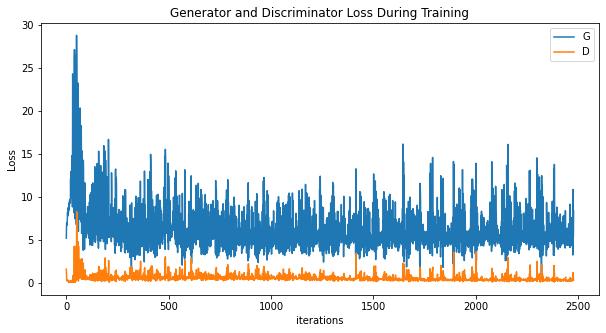

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

<p><strong>Visualization of G’s progression</strong></p>

We saved the generator's output after every epoch by generating a batch of images from a fixed noise vector. Now we will be visualizing the Generator's progression 

NameError: ignored

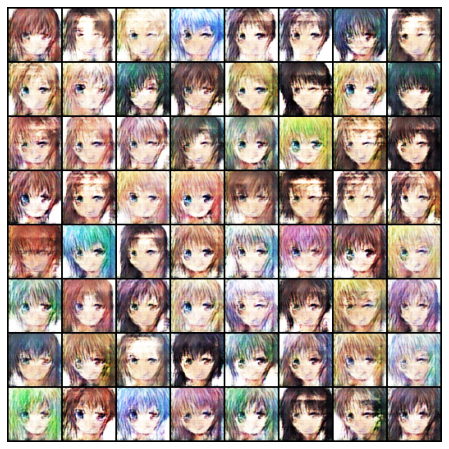

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

<p><strong>Real Images vs. Fake Images</strong></p>
<p>Finally, lets take a look at some real images and fake images side by
side.</p>

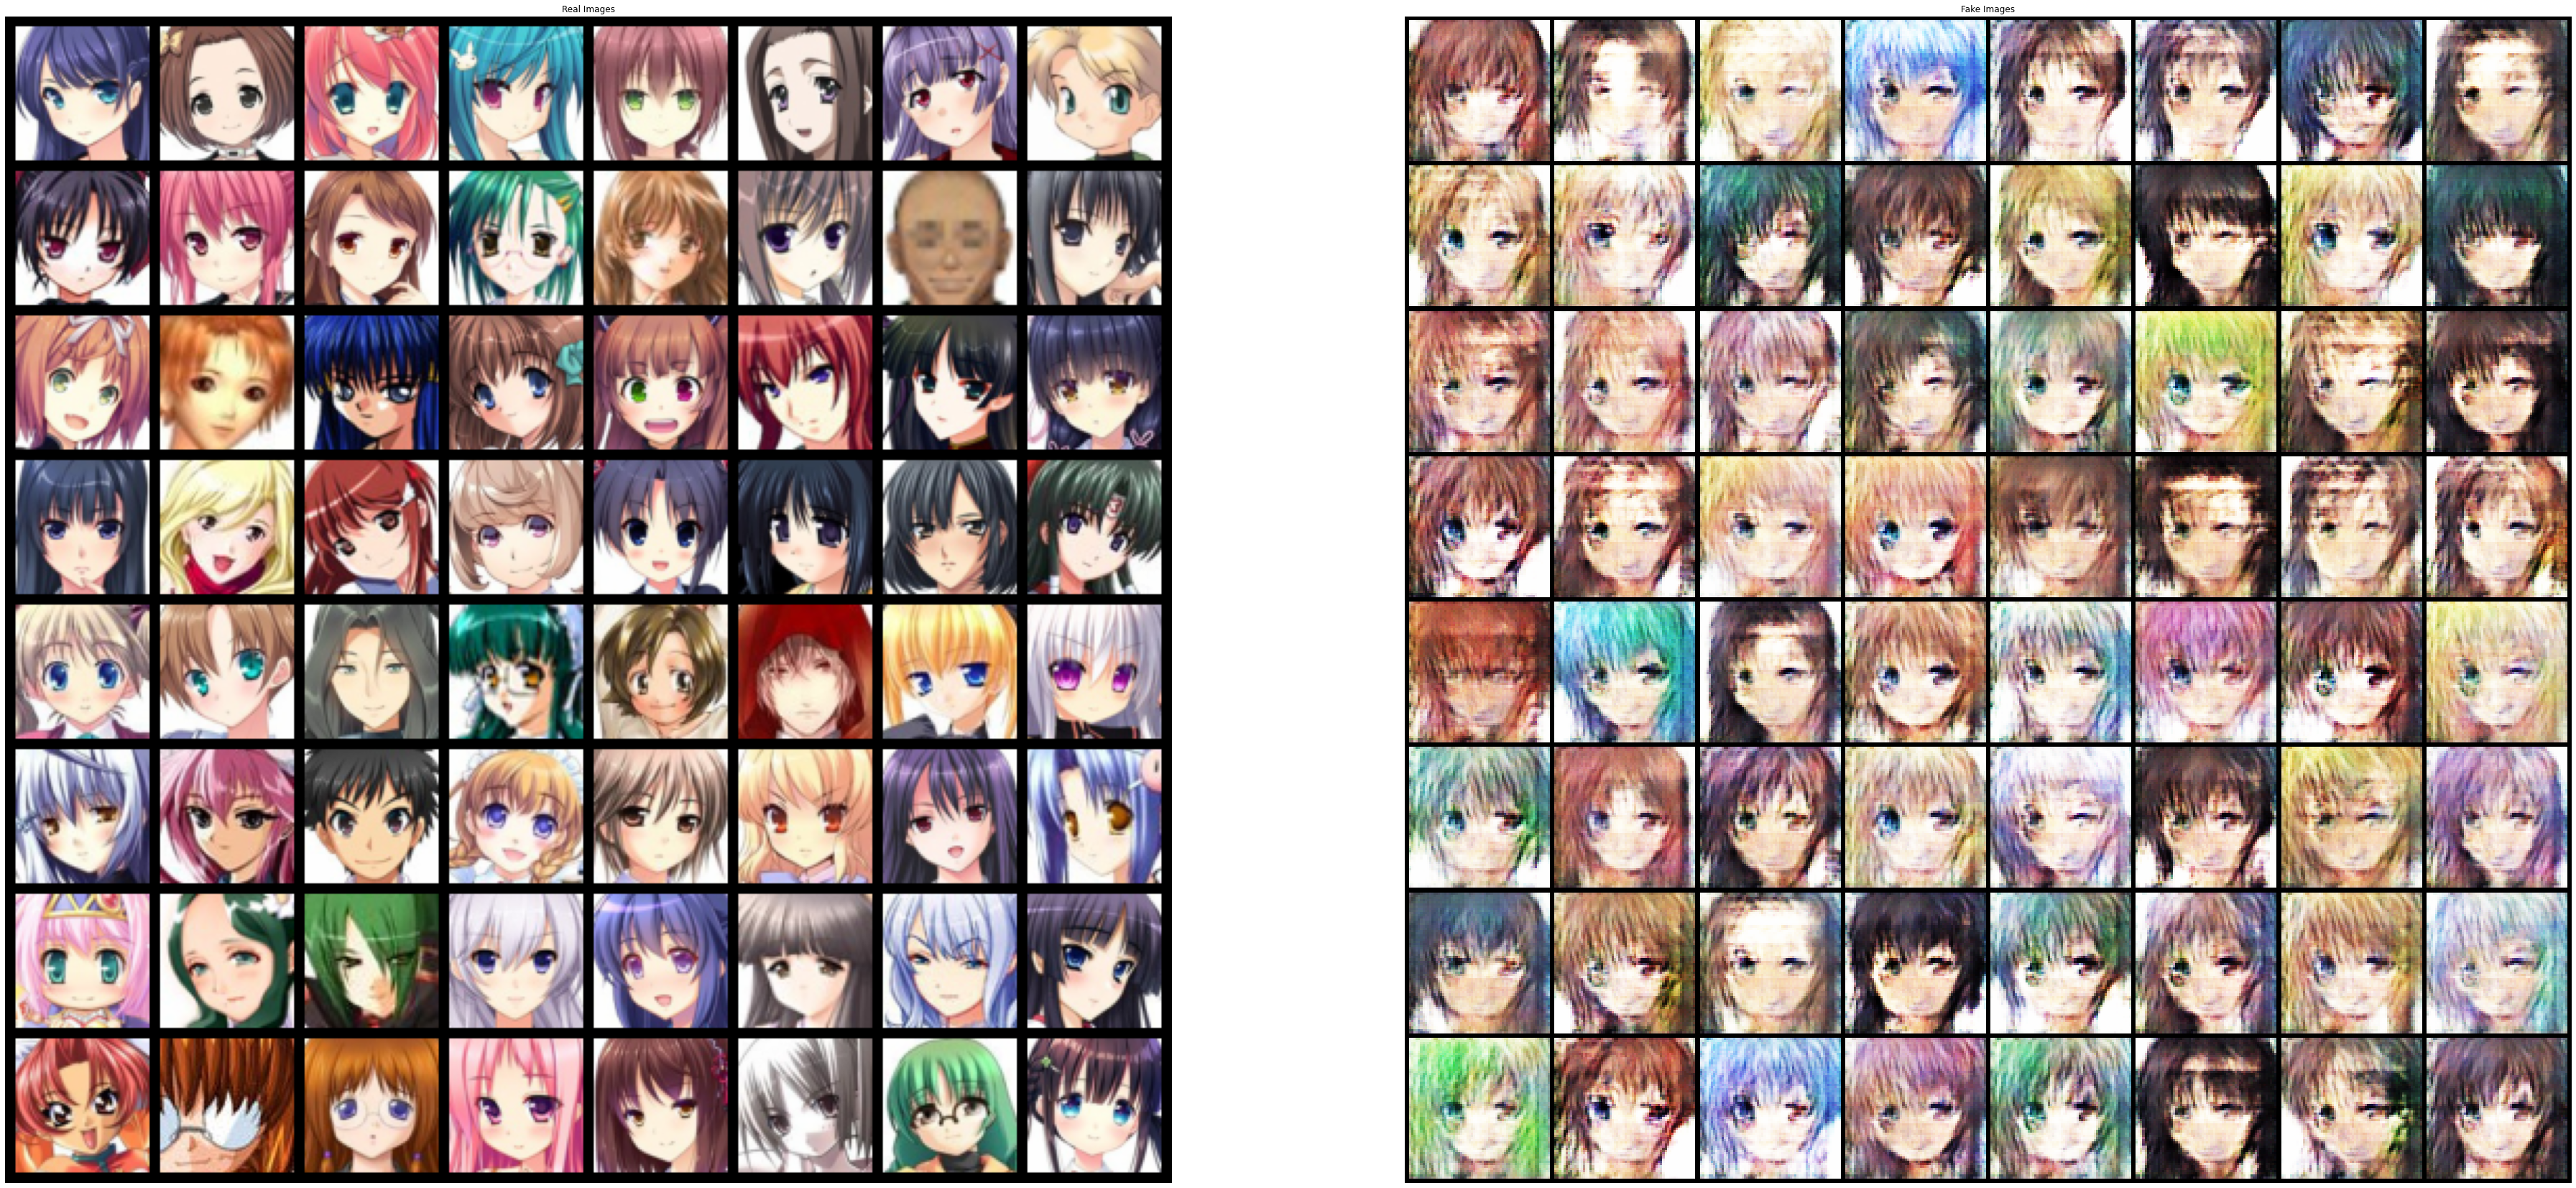

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(64,64))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()